In [12]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, confusion_matrix, roc_curve, precision_recall_curve

In [13]:
data = pd.read_csv("../data/Data_sample_input_final.csv")
print(data.shape)
data.head()

(204356, 4)


,ID,AGE,PROBABILITY_OF_ONCOLOGY,ONCOLOGY_FLAG
0,152154875,51,0.003072,0
1,105099144,63,0.007925,0
2,238820665,67,0.008262,0
3,284268788,34,0.000118,0
4,365820024,19,0.000332,0


In [14]:
# Identifying the right proabbility threshold for screening recommendations in the new approach. 
# This should cover ~28% of the samples OR the number of samples targeted by the current approach
fixed_threshold = round(data["PROBABILITY_OF_ONCOLOGY"].quantile(1- ((data[data.AGE > 50].shape[0]-5) / data.shape[0])),6)
fixed_threshold

0.002604

In [15]:
# # Add column on age group 17-30,31-40,41-50,51-60,61+ & dummy column for current approach
bins = [17,31,41,51,61,102]
labels = ["17-30","31-40","41-50","51-60","61+"]
data["age_group"] = pd.cut(data["AGE"], bins = bins, labels = labels, right=False)
data["current_approach"] = np.where(data.AGE > 50, 1, 0)
data["new_approach"] = np.where(data.PROBABILITY_OF_ONCOLOGY > fixed_threshold, 1, 0)
data["match_current"] = np.where((data.ONCOLOGY_FLAG == data.current_approach) & (data.current_approach == 1), 1, 0)
data["match_new"] = np.where((data.ONCOLOGY_FLAG == data.new_approach) & (data.new_approach == 1), 1, 0)
data["count_flag"] = 1
data.head()

,ID,AGE,PROBABILITY_OF_ONCOLOGY,ONCOLOGY_FLAG,age_group,current_approach,new_approach,match_current,match_new,count_flag
0,152154875,51,0.003072,0,51-60,1,1,0,0,1
1,105099144,63,0.007925,0,61+,1,1,0,0,1
2,238820665,67,0.008262,0,61+,1,1,0,0,1
3,284268788,34,0.000118,0,31-40,0,0,0,0,1
4,365820024,19,0.000332,0,17-30,0,0,0,0,1


In [16]:
temp_data = data.groupby(["age_group"])["ONCOLOGY_FLAG","count_flag","current_approach","new_approach","match_current","match_new"].sum().reset_index()
temp_data["age_gt_50"] = np.where(temp_data["age_group"].isin(["17-30","31-40","41-50"]), 0, 1)
temp_data["default_risk"] = 100*temp_data["ONCOLOGY_FLAG"] / temp_data["count_flag"]
temp_data["cur_recall"] = 100*temp_data["match_current"] / temp_data["ONCOLOGY_FLAG"]
temp_data["new_recall"] = 100*temp_data["match_new"] / temp_data["ONCOLOGY_FLAG"]
temp_data["cur_prec"] = 100*temp_data["match_current"] / temp_data["current_approach"]
temp_data["new_prec"] = 100*temp_data["match_new"] / temp_data["new_approach"]
temp_data

<ipython-input-16-27609a1ddbde>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  temp_data = data.groupby(["age_group"])["ONCOLOGY_FLAG","count_flag","current_approach","new_approach","match_current","match_new"].sum().reset_index()


,age_group,ONCOLOGY_FLAG,count_flag,current_approach,new_approach,match_current,match_new,age_gt_50,default_risk,cur_recall,new_recall,cur_prec,new_prec
0,17-30,109,45403,0,14,0,5,0,0.240072,0.0,4.587156,NaN,35.714286
1,31-40,320,53983,0,97,0,28,0,0.592779,0.0,8.750000,NaN,28.865979
2,41-50,722,47351,0,10481,0,261,0,1.524783,0.0,36.149584,NaN,2.490220
3,51-60,1011,31058,31058,20684,1011,785,1,3.255200,100.0,77.645895,3.255200,3.795204
4,61+,2194,26561,26561,26336,2194,2183,1,8.260231,100.0,99.498633,8.260231,8.289034


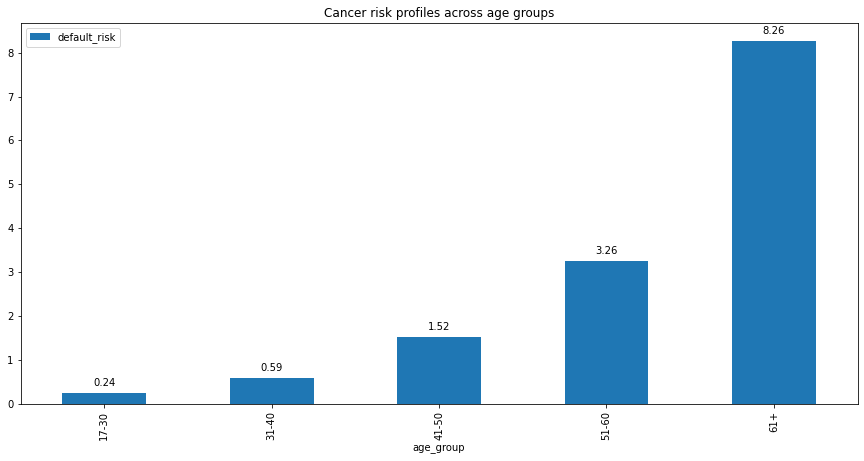

In [17]:
# Cancer risk profile by age
ax = temp_data[["age_group","default_risk"]].plot(x="age_group",y="default_risk",title = "Cancer risk profiles across age groups", kind="bar", figsize=(15,7))
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')


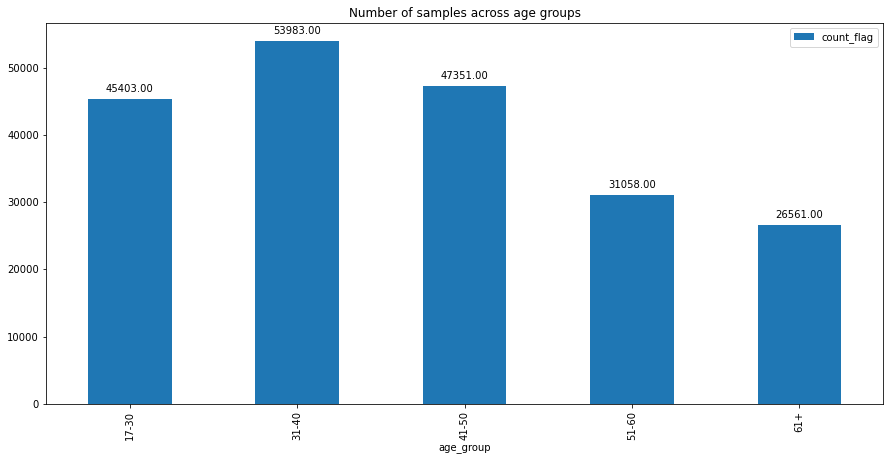

In [18]:
# Number of sample by age bucket
ax = temp_data[["age_group","count_flag"]].plot(x="age_group",y="count_flag",title = "Number of samples across age groups", kind="bar", figsize=(15,7))
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')


In [19]:
# Compute screening positivity rates and case detection rates : overall, age > 50 and age < 50

def compute_metrics(df):
    age_split_data = df[["age_gt_50","ONCOLOGY_FLAG","count_flag","current_approach","new_approach","match_current","match_new"]].groupby("age_gt_50")\
        .sum().reset_index()
    age_no_split_data = df[["age_gt_50","ONCOLOGY_FLAG","count_flag","current_approach","new_approach","match_current","match_new"]].sum(axis=0).reset_index()
    age_less_50_df = age_split_data[age_split_data.age_gt_50==0]
    age_gt_50_df = age_split_data[age_split_data.age_gt_50==1]

    # Screening positivity rate
    print("Screening Positivity rate")
    # New Approach
    print("New Approach")
    x = 100*age_less_50_df.match_new[0]/age_less_50_df.new_approach[0]
    print(f"Age < 50 = {x}")
    x = 100*age_gt_50_df.match_new[1]/age_gt_50_df.new_approach[1]
    print(f"Age > 50 = {x}")
    x = 100*df.match_new.sum()/df.new_approach.sum()
    print(f"Overall = {x}")

    # Current Approach
    print("\nCurrent Approach")
    x = 100*age_less_50_df.match_current[0]/age_less_50_df.current_approach[0]
    print(f"Age < 50 = {x}")
    x = 100*age_gt_50_df.match_current[1]/age_gt_50_df.current_approach[1]
    print(f"Age > 50 = {x}")
    x = 100*df.match_current.sum()/df.current_approach.sum()
    print(f"Overall = {x}") 

    # Case Detection rate
    print("\n\nCase Detection rate")
    # New Approach
    print("New Approach")
    x = 100*age_less_50_df.match_new[0]/age_less_50_df.ONCOLOGY_FLAG[0]
    print(f"Age < 50 = {x}")
    x = 100*age_gt_50_df.match_new[1]/age_gt_50_df.ONCOLOGY_FLAG[1]
    print(f"Age > 50 = {x}")
    x = 100*df.match_new.sum()/df.ONCOLOGY_FLAG.sum()
    print(f"Overall = {x}")

    # Current Approach
    print("\nCurrent Approach")
    x = 100*age_less_50_df.match_current[0]/age_less_50_df.ONCOLOGY_FLAG[0]
    print(f"Age < 50 = {x}")
    x = 100*age_gt_50_df.match_current[1]/age_gt_50_df.ONCOLOGY_FLAG[1]
    print(f"Age > 50 = {x}")
    x = 100*df.match_current.sum()/df.ONCOLOGY_FLAG.sum()
    print(f"Overall = {x}") 

    return 1

compute_metrics(temp_data)


Screening Positivity rate
New Approach
Age < 50 = 2.775679758308157
Age > 50 = 6.312207571246278
Overall = 5.6620148580156915

Current Approach
Age < 50 = nan
Age > 50 = 5.562401291240737
Overall = 5.562401291240737


Case Detection rate
New Approach
Age < 50 = 25.543006081668114
Age > 50 = 92.60530421216849
Overall = 74.8852157943067

Current Approach
Age < 50 = 0.0
Age > 50 = 100.0
Overall = 73.57667584940312


<ipython-input-19-8db2f683ae87>:23: RuntimeWarning: invalid value encountered in long_scalars
  x = 100*age_less_50_df.match_current[0]/age_less_50_df.current_approach[0]


1

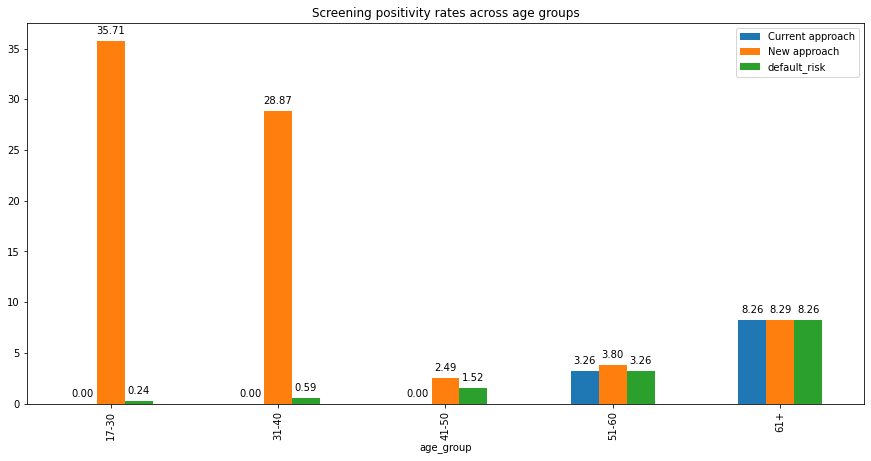

In [20]:
# Screening positivity rate
ax=temp_data[["age_group","cur_prec","new_prec","default_risk"]].rename({'cur_prec':'Current approach', 'new_prec': 'New approach'},axis=1)\
    .plot(kind = "bar", x="age_group", title = "Screening positivity rates across age groups",\
    figsize = (15,7))
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')


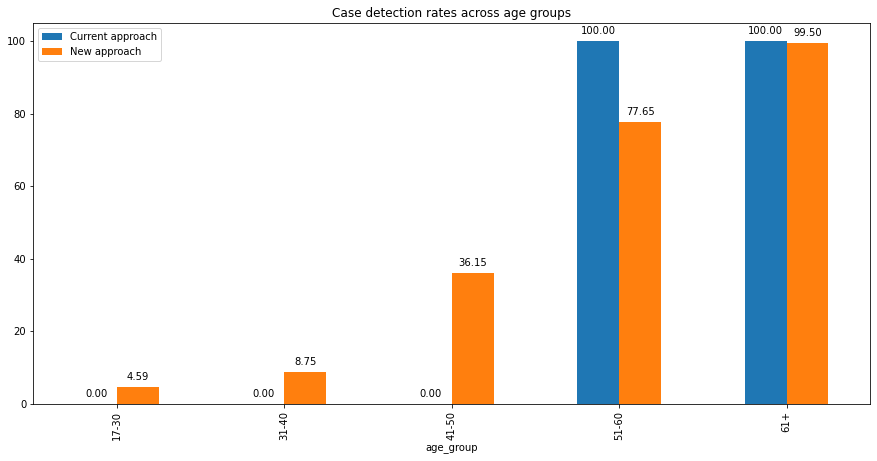

In [21]:
# Case detection rate
ax=temp_data[["age_group","cur_recall","new_recall"]].rename({'cur_recall':'Current approach', 'new_recall': 'New approach'},axis=1)\
    .plot(kind = "bar", x="age_group", title = "Case detection rates across age groups",\
    figsize = (15,7))
for p in ax.patches:
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')


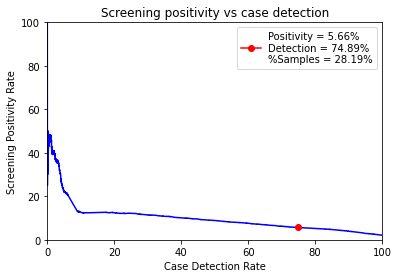

In [22]:
prec, recl, threshold = precision_recall_curve(data["ONCOLOGY_FLAG"], data["PROBABILITY_OF_ONCOLOGY"])
prec, recl = 100*prec, 100*recl

prec = [prec[::-1][0]] + list(prec[::-1][3:])
recl = [recl[::-1][0]] + list(recl[::-1][3:])
threshold = [threshold[::-1][0]] + list(threshold[::-1][3:])
threshold_index = len([i for i in threshold if i > fixed_threshold])
plot_point = (prec[threshold_index], recl[threshold_index])

new_line='\n'
label = f"Positivity = {prec[threshold_index]:.2f}% {new_line}Detection = {recl[threshold_index]:.2f}% {new_line}"\
    f"%Samples = {100*data[data.PROBABILITY_OF_ONCOLOGY>fixed_threshold].shape[0]/data.shape[0]:.2f}%"

plt.title('Screening positivity vs case detection')
plt.plot(recl, prec, 'b')
plt.plot(plot_point[1],plot_point[0], 'r', marker = 'o', label=label)
plt.legend(loc = 'upper right')
# plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 100])
plt.ylim([0, 100])
plt.ylabel('Screening Positivity Rate')
plt.xlabel('Case Detection Rate')
plt.show()